In [1]:
import random
import pandas as pd
pd.options.display.max_columns = 0

import matplotlib.pyplot as plt

%matplotlib inline

%config InlineBackend.figure_format = "retina"

In [2]:
import os

parts_dir = "../data/1-feature-engineering"

parts_names = os.listdir(parts_dir)
parts_names = filter(lambda x: not x.startswith("."), parts_names)
parts_paths = sorted(map(lambda part_name: parts_dir + "/" + part_name, parts_names))

parts_paths[:5]

['../data/1-feature-engineering/new.000.csv',
 '../data/1-feature-engineering/new.001.csv',
 '../data/1-feature-engineering/new.002.csv',
 '../data/1-feature-engineering/new.003.csv',
 '../data/1-feature-engineering/new.004.csv']

In [3]:
%%time

parts_dfs = tuple(map(pd.read_csv, parts_paths))

with pd.option_context("display.max_rows", 6): display(random.choice(parts_dfs))

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.installments),SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.installments),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.installments),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.installments),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.installments),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.installments),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),PERCENT_TRUE(transactions.category_3_-1),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.merchant_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),COUNT(transactions WHERE category_1 = 1),COUNT(transactions WHERE category_2_5 = 1),COUNT(transactions WHERE category_2_2 = 1),COUNT(transactions WHERE authorized_flag = 1),COUNT(transactions WHERE installments = 999),COUNT(transactions WHERE category_3_2 = 1),COUNT(transactions WHERE category_3_1 = 1),COUNT(transactions WHERE category_3_-1 = 1),COUNT(transactions WHERE category_2_-1 = 1),COUNT(transactions WHERE category_2_1 = 1),COUNT(transactions WHERE category_3_0 = 1),COUNT(transactions WHERE category_2_4 = 1),COUNT(transactions WHERE category_2_3 = 1),COUNT(transactions WHERE installments = -1),NUM_UNIQUE(transactions.DAY(purchase_date)),NUM_UNIQUE(transactions.YEAR(purchase_date)),NUM_UNIQUE(transactions.MONTH(purchase_date)),NUM_UNIQUE(transactions.WEEKDAY(purchase_date)),MODE(transactions.DAY(purchase_date)),MODE(transactions.YEAR(purchase_date)),MODE(transactions.MONTH(purchase_date)),MODE(transactions.WEEKDAY(purchase_date))
0,0.847922,0,0,0,0,1,0,1,0,5,2,1,0,-56,-15.021583,321,0.000000,1.646652,0.127969,0.208514,0,0,-0.115794,14,0.000000,0.643336,3.685072,-4.795832,0,-4,-0.741363,13,0.000000,-2.434783,-0.653112,13.956522,23,0.956522,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2,10,14,2,8,1,1,296,195,M_ID_5d2cdf15e4,15,34,1,0,1,2017,7,5,0.0,0.0,0.0,22,0.0,0.0,0.0,0.0,0.0,23.0,23.0,0.0,0.0,0.0,13,1,5,7,6,2017,7,3
1,-0.905887,0,0,0,0,1,0,1,0,5,2,1,3,-216,-37.589435,1522,0.145328,1.034453,1.011509,0.335927,1,0,9.526027,11,6.681535,0.175613,7.066854,-2.243414,0,-3,-0.745405,10,0.021429,-1.542857,-0.268496,10.871429,140,0.957143,0.000000,0.107143,0.0,0.000000,0.000000,0.892857,0.000000,0.978571,0.021429,0.000000,0.000000,9,16,37,4,11,2,2,57,705,M_ID_f0cf0216ba,5,33,5,0,1,2017,11,2,0.0,125.0,0.0,134,0.0,0.0,3.0,0.0,0.0,15.0,137.0,0.0,0.0,0.0,30,2,4,7,23,2017,12,5
2,0.573943,0,0,1,0,0,1,0,0,3,1,1,0,-77,5.516803,204,0.000000,3.407079,0.849027,0.452414,0,0,1.335842,11,0.000000,-0.401916,-0.277032,-1.170193,0,-10,-0.732813,10,0.000000,-4.052632,0.290358,10.

CPU times: user 4.34 s, sys: 300 ms, total: 4.64 s
Wall time: 4.64 s


In [4]:
%%time

feature_matrix = pd.concat(parts_dfs, ignore_index=True, sort=False)

with pd.option_context("display.max_rows", 6): display(feature_matrix)

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.installments),SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.installments),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.installments),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.installments),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.installments),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.installments),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),PERCENT_TRUE(transactions.category_3_-1),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.merchant_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),COUNT(transactions WHERE category_1 = 1),COUNT(transactions WHERE category_2_5 = 1),COUNT(transactions WHERE category_2_2 = 1),COUNT(transactions WHERE authorized_flag = 1),COUNT(transactions WHERE installments = 999),COUNT(transactions WHERE category_3_2 = 1),COUNT(transactions WHERE category_3_1 = 1),COUNT(transactions WHERE category_3_-1 = 1),COUNT(transactions WHERE category_2_-1 = 1),COUNT(transactions WHERE category_2_1 = 1),COUNT(transactions WHERE category_3_0 = 1),COUNT(transactions WHERE category_2_4 = 1),COUNT(transactions WHERE category_2_3 = 1),COUNT(transactions WHERE installments = -1),NUM_UNIQUE(transactions.DAY(purchase_date)),NUM_UNIQUE(transactions.YEAR(purchase_date)),NUM_UNIQUE(transactions.MONTH(purchase_date)),NUM_UNIQUE(transactions.WEEKDAY(purchase_date)),MODE(transactions.DAY(purchase_date)),MODE(transactions.YEAR(purchase_date)),MODE(transactions.MONTH(purchase_date)),MODE(transactions.WEEKDAY(purchase_date))
0,0.492829,0,0,0,1,0,1,0,0,4,1,0,9,13,-6.044384,99,0.000000,0.527046,0.054186,0.000000,1,2,-0.563554,11,0.00000,0.271052,1.109994,0.000000,1,1,-0.735788,11,1.000000,1.444444,-0.671598,11.000000,9,1.000000,0.00000,1.000000,0.0,0.0000,0.000000,0.000000,0.00000,0.0,1.000000,0.000000,0.0,1,8,9,1,7,1,1,175,307,M_ID_1fc4f20073,16,19,1,1,1,2017,5,0,0.0,0.0,0.0,9,0.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,8,1,2,6,11,2018,3,6
1,2.322680,0,1,0,0,0,1,0,0,2,1,0,1,2,-0.741047,13,NaN,NaN,NaN,NaN,1,2,-0.741047,13,NaN,NaN,NaN,NaN,1,2,-0.741047,13,1.000000,2.000000,-0.741047,13.000000,1,1.000000,0.00000,0.000000,0.0,0.0000,0.000000,1.000000,0.00000,0.0,1.000000,0.000000,0.0,1,1,1,1,1,1,1,143,560,M_ID_bae31a9f9e,5,34,5,1,1,2017,8,1,0.0,1.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,10,2018,2,5
2,0.856304,0,0,0,0,1,0,1,0,5,2,1,0,3,-0.855369,22,0.000000,0.707107,0.303651,0.000000,0,2,-0.212971,11,NaN,NaN,NaN,NaN,0,1,-0.642398,11,0.000000,1.500000,-0.427685,11.000000,2,1.000000,0.00000,0.000000,0.0,0.0000,0.000000,1.000000,0.00000,1.0,0.000000,0.000000,0.0,1,2,2,1,2,1,1,223,108,M_ID_4e754

CPU times: user 942 ms, sys: 60.1 ms, total: 1 s
Wall time: 914 ms


In [5]:
customers = feature_matrix.drop("MODE(transactions.merchant_id)", axis=1).fillna(0)

customers_ord = customers[customers.target > -33].sample(2000)
customers_ano = customers[customers.target < -33].sample(2000)

In [6]:
%%time

from sklearn.manifold import TSNE

X = pd.concat((customers_ano, customers_ord))
y = (X.target < -33).astype(int)
X = X.drop("target", axis=1)

X_t = TSNE(random_state=13).fit_transform(X)

CPU times: user 23.7 s, sys: 27.9 ms, total: 23.8 s
Wall time: 21.7 s


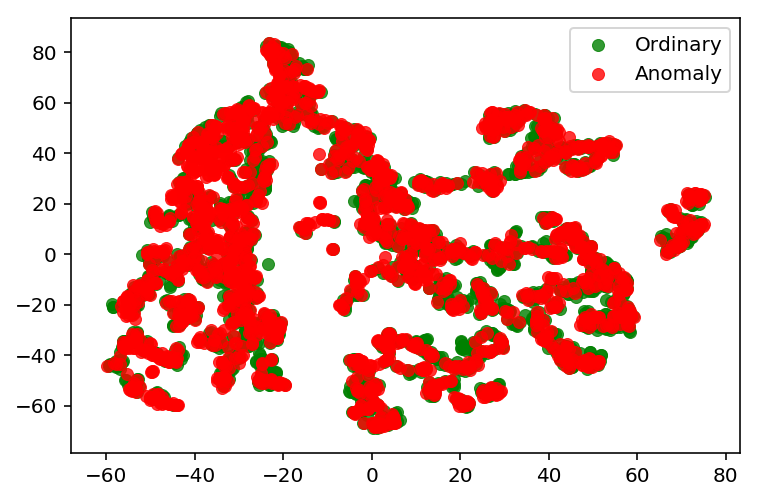

In [7]:
X_t_ord = X_t[y == 0]
X_t_ano = X_t[y == 1]

plt.scatter(X_t_ord[:, 0], X_t_ord[:, 1], marker='o', color='g', linewidth='0.5', alpha=0.8, label='Ordinary')
plt.scatter(X_t_ano[:, 0], X_t_ano[:, 1], marker='o', color='r', linewidth='0.5', alpha=0.8, label='Anomaly')

plt.legend(loc='best')
plt.show()

In [54]:
from keras.layers import Input, Dense
import keras.regularizers as regularizers

## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(256, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(128, activation='relu')(encoded)

## decoding part
decoded = Dense(128, activation='tanh')(encoded)
decoded = Dense(256, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [55]:
from keras.models import Model

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [56]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X.values)
X_scaled_ord = X_scaled[y == 0]
X_scaled_ano = X_scaled[y == 1]

In [57]:
autoencoder.fit(X_scaled_ord, X_scaled_ord, 
                batch_size=64, epochs=35,
                shuffle=True,
                validation_split=0.20);

Train on 1600 samples, validate on 400 samples
Epoch 1/35
1600/1600 [==============================] - 1s 513us/step - loss: 0.3314 - val_loss: 0.2461
Epoch 2/35
1600/1600 [==============================] - 0s 89us/step - loss: 0.2294 - val_loss: 0.2085
Epoch 3/35
1600/1600 [==============================] - 0s 67us/step - loss: 0.1973 - val_loss: 0.1821
Epoch 4/35
1600/1600 [==============================] - 0s 90us/step - loss: 0.1734 - val_loss: 0.1628
Epoch 5/35
1600/1600 [==============================] - 0s 72us/step - loss: 0.1575 - val_loss: 0.1501
Epoch 6/35
1600/1600 [==============================] - 0s 67us/step - loss: 0.1456 - val_loss: 0.1394
Epoch 7/35
1600/1600 [==============================] - 0s 66us/step - loss: 0.1370 - val_loss: 0.1318
Epoch 8/35
1600/1600 [==============================] - 0s 67us/step - loss: 0.1282 - val_loss: 0.1227
Epoch 9/35
1600/1600 [==============================] - 0s 66us/step - loss: 0.1195 - val_loss: 0.1151
Epoch 10/35
1600/1600 [==

In [58]:
from keras.models import Sequential

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [59]:
ord_hid_rep = hidden_representation.predict(X_scaled_ord)
ano_hid_rep = hidden_representation.predict(X_scaled_ano)

In [60]:
import numpy as np

rep_x = np.append(ord_hid_rep, ano_hid_rep, axis = 0)

In [61]:
%%time

X_t = TSNE(random_state=13).fit_transform(rep_x)

CPU times: user 25.2 s, sys: 2.28 s, total: 27.5 s
Wall time: 24.6 s


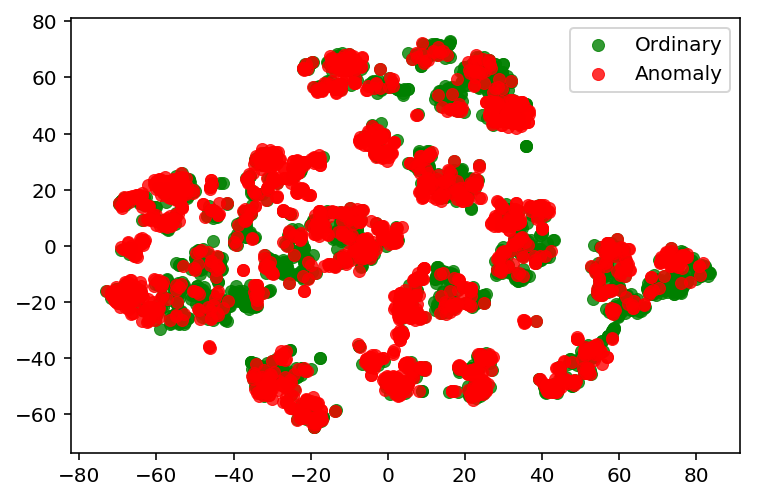

In [62]:
X_t_ord = X_t[y == 0]
X_t_ano = X_t[y == 1]

plt.scatter(X_t_ord[:, 0], X_t_ord[:, 1], marker='o', color='g', linewidth='0.5', alpha=0.8, label='Ordinary')
plt.scatter(X_t_ano[:, 0], X_t_ano[:, 1], marker='o', color='r', linewidth='0.5', alpha=0.8, label='Anomaly')

plt.legend(loc='best')
plt.show()